### scMKL
This is an introduction to single cell Multiple Kernel Learning. scMKL is a classification algorithm utilizing prior information to group features to enhance classification and aid understanding of distinguishing features in multi-omic data sets.

In [1]:
# Packages needed to import data
import numpy as np
import pickle
import sys

# This sys command allows us to import the scMKL_src module from any directory. '..' can be replaced by any path to the module
sys.path.insert(0, '..')
import src.scMKL_src as src
import src.scMKL_util as util

seed = np.random.default_rng(1)

#### Inputs for scMKL
There are 4 required pieces of data (per modality) required for scMKL
- The data matrix itself with cells as rows and features as columns.
    - Can be either a Numpy Array or Scipy Sparse array (scipy.sparse.csc_array is the recommended format).  
- The sample labels in a Numpy Array.  To perform group lasso, these labels must be binary.
- Feature names in a Numpy Array. These are the names of the features corresponding with the data matrix
- A dictionary with grouping data.  The keys are the names of the groups, and the values are the corresponding features.
    - Example: {Group1: [feature1, feature2, feature3], Group2: [feature4, feature5, feature6], ...}

In [2]:
X = np.load('./data/TCGA-ESCA.npy', allow_pickle = True)
labels = np.load('./data/TCGA-ESCA_cell_metadata.npy', allow_pickle = True)
features = np.load('./data/TCGA-ESCA_RNA_feature_names.npy', allow_pickle = True)


with open('./data/RNA_hallmark_groupings.pkl', 'rb') as fin:
    group_dict = pickle.load(fin)

# This value for D, the number of fourier features in Z, was found to be optimal in previous literature.  Generally increasing D increases accuracy, but runs slower.
D = int(np.sqrt(len(labels)) * np.log(np.log(len(labels))))

# Removes features in X and features that are not found in group_dict.  Done to reduce memory usage and search time
X, features = src.Filter_Features(X, features, group_dict)

#### Parameter Optimization
Kernel widths (sigma) are a parameter of the kernel approximation.  Here we estimate sigma on a random 2000 samples from the training set before optimizing it with k-Fold Cross Validation on the full training set.

In [3]:
# The train/test sets are calculated to keep the proportion of each label the same in the training and testing sets.
train_indices, test_indices = src.Train_Test_Split(labels, seed_obj= seed)

X_train = X[train_indices,:]
X_test = X[test_indices,:]
y_train = labels[train_indices]
y_test = labels[test_indices]

sigmas = src.Estimate_Sigma(X= X_train, group_dict= group_dict, assay= 'rna', feature_set= features, seed_obj= seed)

sigmas = src.Optimize_Sigma(X = X_train, y = y_train, group_dict = group_dict, assay = 'rna', D = D, feature_set = features, 
                            sigma_list = sigmas, k = 2, sigma_adjustments = np.arange(0.1,2,0.1), seed_obj= seed)

#### Calculating Z and Model Evaluation
Below, we calculate approximate kernels for each group in the grouping information.

Then we train the model to view the distinguishing feature groups between phenotypes and evaluate on a test set to quantify classification performance.

In [4]:
Z_train, Z_test = src.Calculate_Z(X_train= X_train, X_test= X_test, group_dict= group_dict, assay= 'rna', D= D, feature_set= features, sigma_list= sigmas, seed_obj= seed)

norm_dict = {}
selected_dict = {}
metric_dict = {}
predictions_dict = {}
for alpha in np.round(np.linspace(1.9,0.1,10),2):
    model = src.Train_Model(Z_train, y_train, 2 * D, alpha)
    predictions_dict[alpha], metric_dict[alpha] = src.Predict(model, Z_test, y_test, metrics = ['AUROC', 'F1-Score', 'Accuracy', 'Precision', 'Recall'])
    selected_dict[alpha] = src.Find_Selected_Pathways(model, group_names= group_dict.keys())
    norm_dict[alpha] = [np.linalg.norm(model.coef_[i * 2 * D: (i + 1) * 2 * D - 1]) for i in np.arange(len(group_dict.keys()))]

/home/skupp/miniconda3/envs/scMKL_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


In [5]:
print(metric_dict[alpha])
print(selected_dict[alpha])

{'AUROC': 1.0, 'Accuracy': 1.0, 'F1-Score': 1.0, 'Precision': 1.0, 'Recall': 1.0}
['HALLMARK_CHOLESTEROL_HOMEOSTASIS' 'HALLMARK_MITOTIC_SPINDLE'
 'HALLMARK_NOTCH_SIGNALING' 'HALLMARK_ESTROGEN_RESPONSE_EARLY'
 'HALLMARK_PROTEIN_SECRETION' 'HALLMARK_PI3K_AKT_MTOR_SIGNALING'
 'HALLMARK_GLYCOLYSIS' 'HALLMARK_UV_RESPONSE_UP' 'HALLMARK_ANGIOGENESIS'
 'HALLMARK_PANCREAS_BETA_CELLS']


/home/skupp/miniconda3/envs/scMKL_test/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/skupp/miniconda3/envs/scMKL_test/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/skupp/miniconda3/envs/scMKL_test/lib/python3.11/site-packages/mizani/scale.py:210: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/skupp/miniconda3/envs/scMKL_test/lib/python3.11/site-packages/mizani/scale.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


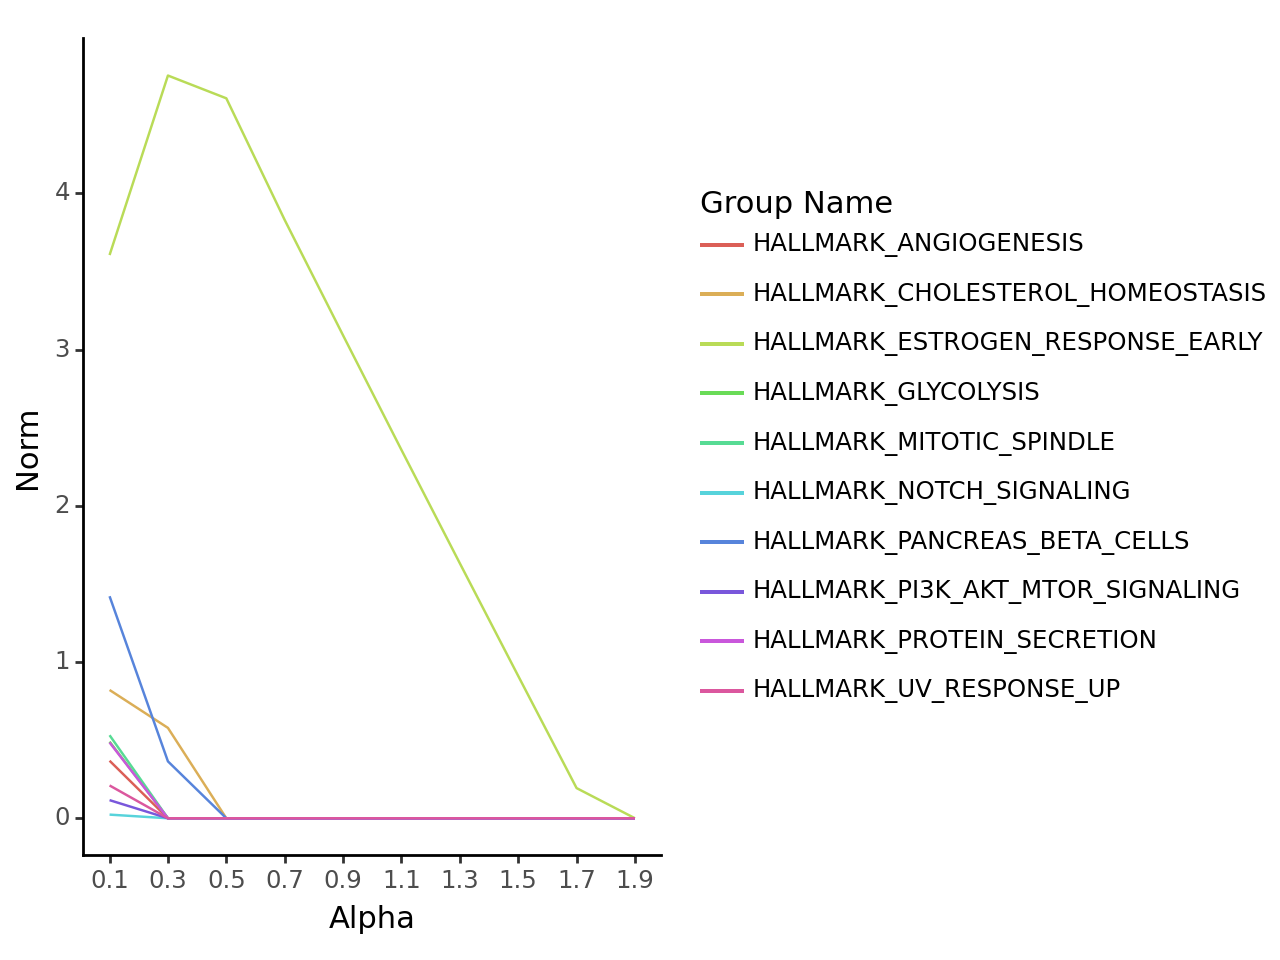

<Figure Size: (640 x 480)>

In [6]:
util.plot_group_norms(norm_dict= norm_dict, group_names= list(group_dict.keys()), groups_to_display= 10)

/mnt/c/Users/kupp/Documents/scMKL_pkg/scMKL/example/../src/scMKL_util.py:66: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['AUROC', 'Accuracy', 'F1-Score', 'Precision', 'Recall']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
/home/skupp/miniconda3/envs/scMKL_test/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/skupp/miniconda3/envs/scMKL_test/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/skupp/miniconda3/envs/scMKL_test/lib/python3.11/site-packages/mizani/scale.py:210: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dt

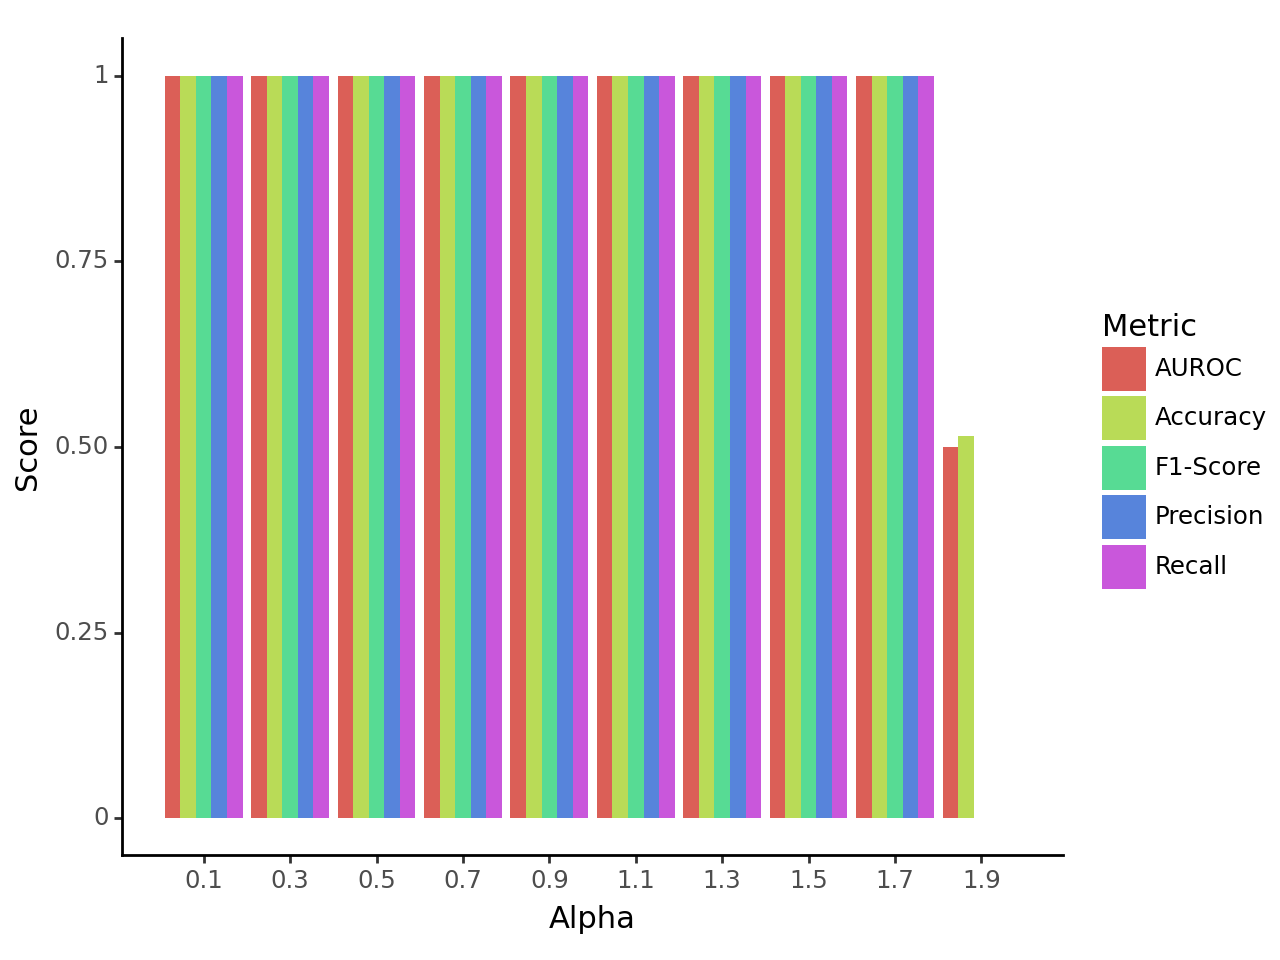

<Figure Size: (640 x 480)>

In [7]:
util.plot_classification_metrics(metric_dict)